In [1]:
import os
import pandas as pd
import numpy as np
from edgar import Company
import re
from matplotlib import pyplot as pp
import nltk as nltk

import pickle

# Load data and get unique ciks
These come from https://www.kaggle.com/finnhub/sec-filings?select=2021.QTR1.csv which has data back to '94!

In [2]:
os.chdir('/home/lawrence/Personal/Masters/COMP0087_ Natural_Language_Processing/Project/Data/AllEdgarFilings')

In [3]:
read_files = [
    '2020.QTR1.csv',
    '2020.QTR2.csv',
    '2020.QTR3.csv',
    '2020.QTR4.csv',
]

In [4]:
# pull data from finhub sec filings
ciks = []
for fn in read_files:
    frame = pd.read_csv('2020.QTR1.csv')
    ciks.append(frame[frame.form=='10-K'].loc[:, ['symbol', 'cik']])
ciks = pd.concat(ciks)

In [5]:
# remove null data
ciks = ciks[~pd.isnull(ciks['symbol'])]
ciks = ciks[~pd.isnull(ciks['cik'])]

# multiple dupicate filings so drop these
ciks = ciks.drop_duplicates()

# Manually Classify Data

In [6]:
my_path = '/home/lawrence/Personal/Masters/COMP0087_ Natural_Language_Processing/Project/Data/ClassifiedSections'
os.chdir(my_path)

In [7]:
tickers = set([x.split('_')[0] for x in os.listdir(my_path)])

loop_over = [(x, y) for x, y in zip(ciks['symbol'].values, ciks['cik'].values)]
for ticker, cik in loop_over:
    if ticker in tickers:
        continue
    company = Company(ticker, str(cik))
    tree = company.get_all_filings(filing_type = "10-K")
    docs = Company.get_documents(tree, no_of_documents=5)
    fs_text = docs[0].text_content().lower()
    
    item_symbol = re.compile('item\s\d.')
    sections = item_symbol.split(fs_text)
    
    found_bd = False
    
    for i, section in enumerate(sections):
        tokenised = re.split(r'[\s\n]+', section)
        if (len(tokenised) > 2000) and (len(tokenised) < 200000):
            if not found_bd:
                decision = input(' '.join(tokenised[:50]))
            if decision == '0' or found_bd:
                # not a business description
                fn = f'{ticker}_section{i}_0.txt'
            else:
                fn = f'{ticker}_section{i}_1.txt'
                found_bd = True
            f = open(fn, 'a')
            f.write(section)
            f.close()

 business.overviewtactile systems technology, inc. (“we,” “us,” and “our”) is a medical technology company that develops and provides innovative medical devices for the treatment of chronic diseases. we were originally incorporated in minnesota under the name tactile systems technology, inc. on january 30, 1995. during 2006, we established a merger1


KeyboardInterrupt: Interrupted by user

In [ ]:
len(set([x.split('_')[0] for x in os.listdir(my_path)]))

# Train Classifier

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix

In [9]:
n_features = 1000
n_subspace = 30

In [10]:
file_names = os.listdir(my_path)
y = []
X_raw = []
for fn in file_names:
    fn_first = fn.split('.')[0]
    y.append(int(fn_first.split('_')[2]))
    f = open(fn, 'r')
    f_text = f.read()
    f.close()
    X_raw.append(f_text)

In [11]:
y = np.array(y)
X_train, X_valid, y_train, y_valid = train_test_split(X_raw, y)

In [12]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
tf_vectorizer.fit(X_train)

X_train = tf_vectorizer.transform(X_train)
X_valid = tf_vectorizer.transform(X_valid)

In [13]:
svd = TruncatedSVD(n_components=n_subspace, n_iter=7, random_state=42)
svd.fit(X_train)

X_train = svd.transform(X_train)
X_valid = svd.transform(X_valid)

In [14]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

In [15]:
# svc_classifier = SVC(C=1, kernel='rbf', class_weight='balanced')
svc_classifier = SVC(C=1, kernel='rbf', gamma=10, class_weight={0: 1, 1: 2.5})
svc_classifier.fit(X_train, y_train);

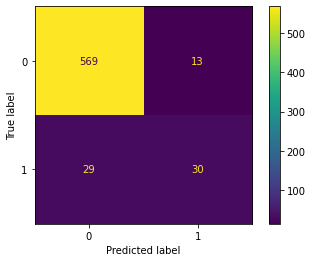

In [16]:
plot_confusion_matrix(svc_classifier, X_train, y_train)

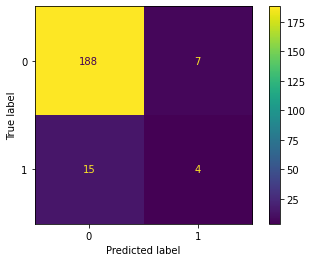

In [17]:
plot_confusion_matrix(svc_classifier, X_valid, y_valid)

# Problem here is getting classifer to be sparse, but not too sparse!

In [ ]:
svc_classifier.predict(X_train)[:20]

In [ ]:
y_train[:20]

# Automatically Scrape and Classify

# Note could search all documents!!

In [ ]:
my_path = '/home/lawrence/Personal/Masters/COMP0087_ Natural_Language_Processing/Project/Data/AutoClassifiedSections'
os.chdir(my_path)

loop_over = [(x, y) for x, y in zip(ciks['symbol'].values, ciks['cik'].values)]

while 1:
    passed = True
#     try:
    tickers = set([x.split('_')[0] for x in os.listdir(my_path)])
    for ticker, cik in loop_over:
        print(f'Processing {ticker}')
        if ticker in tickers:
            continue
        company = Company(ticker, str(cik))
        tree = company.get_all_filings(filing_type = "10-K")
        docs = Company.get_documents(tree, no_of_documents=5)
        fs_text = docs[0].text_content().lower()

        item_symbol = re.compile('item\s\d.')
        sections = item_symbol.split(fs_text)
        lengths = [len(re.split(r'[\s\n]+', x)) for x in sections]
        sections = [x for x, y in zip(sections, lengths) if (y > 2000) and (y < 200000)]
        print(f'Found {len(sections)} sections')

        X_classify = tf_vectorizer.transform(sections)
        X_classify = svd.transform(X_classify)
        X_classify = scaler.transform(X_classify)
        y_hat = svc_classifier.predict(X_classify)

        for i, section in enumerate(sections):
            if y_hat[i] == 0:
                # not a business description
                fn = f'{ticker}_section{i}_0.txt'
            else:
                fn = f'{ticker}_section{i}_1.txt'
            f = open(fn, 'a')
            f.write(section)
            f.close()
                
#     except:
#         passed = False
        
    if passed:
        break

In [ ]:
svc_classifier.predict(X_classify)

In [ ]:
sections